# Module 04 - Custom Datasets in PyTorch

We've used some datasets with pytorch before, but how do you get your own data? --> **Custom Datasets**

Depending on what you-re working on ***(vision, text, audio, recommendation)***, you should look into PyTorch domain libraries for existing data loading functions ans customizable data loading functions.

In [3]:
# Libraries

# PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Others
from pathlib import Path

# Random Seed
MY_SEED = 42

# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using Device: {device}')


Using Device: cuda


### 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 100 images per class (750 training, 250 testing)
Ourdataset starts 3 different classes of food and only 10% of the images per class (~75 training, 25 testing)

Why? When strating out ML Projects, it's important to keep things small scale to speed up training and experimentation.

In [7]:
# Libraries
import requests
import zipfile
from pathlib import Path

# Set up a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If image folder doesn's exist, downloaded and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')

else:
    print(f'{image_path} does not axist, creating one...')
    image_path.mkdir(parents=True, exist_ok=True, )

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading Pizza, Steak and Sushi Data...')
    f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping Pizza, Steak and Sushi Data...')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping Pizza, Steak and Sushi Data...


### 2. Becoming one with the data (Data Preparation and Data Exploration)

In [27]:
import os
def walk_through_dir(dir_path):
    """Wlaks through `dir_path` returning its contents"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories {dirnames if len(dirnames)!=0 else ''} and {len(filenames)} images in {dirpath}.')

walk_through_dir(image_path)

There are 2 directories ['test', 'train'] and 0 images in data\pizza_steak_sushi.
There are 3 directories ['pizza', 'steak', 'sushi'] and 0 images in data\pizza_steak_sushi\test.
There are 0 directories  and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories  and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories  and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories ['pizza', 'steak', 'sushi'] and 0 images in data\pizza_steak_sushi\train.
There are 0 directories  and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories  and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories  and 72 images in data\pizza_steak_sushi\train\sushi.


In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1. Visualizing Image

1. Get all the images paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using Python's `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL.
5. We'll then show the image and print metadata.

===== Random Image Metadata =====
Image Path:   data\pizza_steak_sushi\train\pizza\1285298.jpg
Image Class:  pizza
Image Height: 341 px
Image Width:  512 px


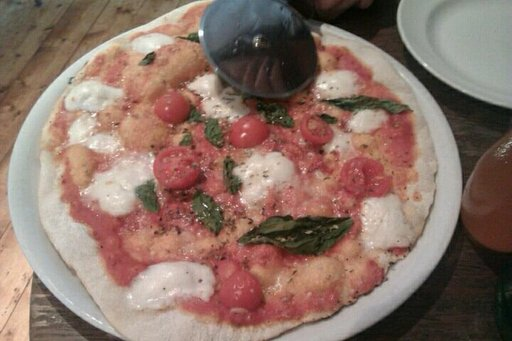

In [88]:
import random
from PIL import Image

# random.seed(MY_SEED)

# 1. Get all images path
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)
# print(f'Random Image Path:  {random_image_path}')

# 3. Det image class
image_class = random_image_path.parent.stem
# print(f'Random Image Class: {image_class}')

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print MetaData
print(f'===== Random Image Metadata =====')
print(f'Image Path:   {random_image_path}')
print(f'Image Class:  {image_class}')
print(f'Image Height: {img.height} px')
print(f'Image Width:  {img.width} px')
img

Text(0.5, 1.0, 'Image Class: pizza | Image Shape: (341, 512, 3) (HWC)')

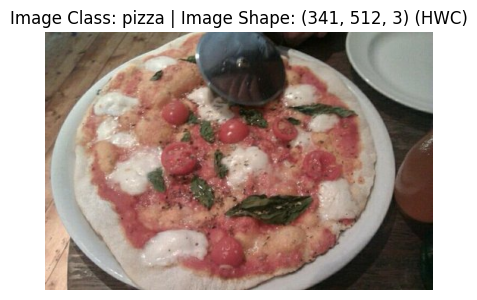

In [89]:
import matplotlib.pyplot as plt
import numpy as np

img_array = np.array(img)

plt.figure(figsize=(5,5))
plt.imshow(img_array); plt.axis(False)
plt.title(f'Image Class: {image_class} | Image Shape: {img_array.shape} (HWC)')

### 3. Transforming Data

Before we can use out image data with PyTorch:
1. Turn yout target data into tensors (in our case, numerical representation) of our images 
2. Turn it into a `torch.utils.data.Dataset` and a `torch.utils.data.DataLoader`, we'll call these  `Dataset` & `DataLoader`

In [94]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

#### 3.1. Transforming Data with `torchvision.transforms()`

In [112]:
data_transform = transforms.Compose(
    [transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()]
)

data_transform(img).shape

torch.Size([3, 64, 64])

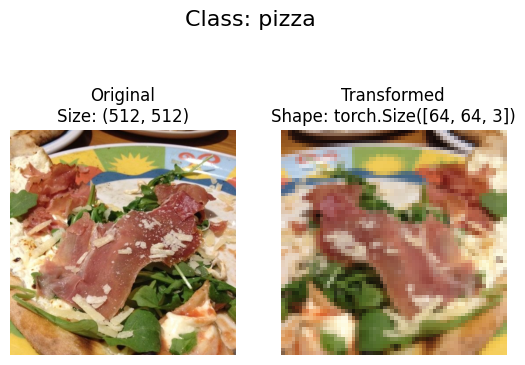

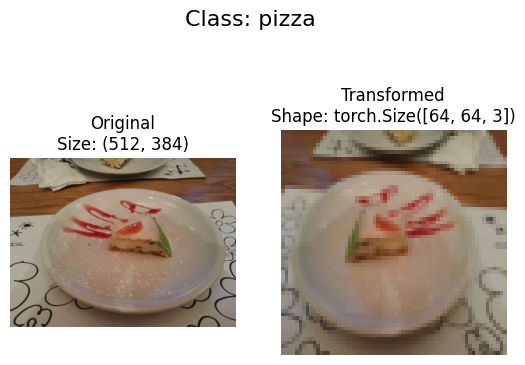

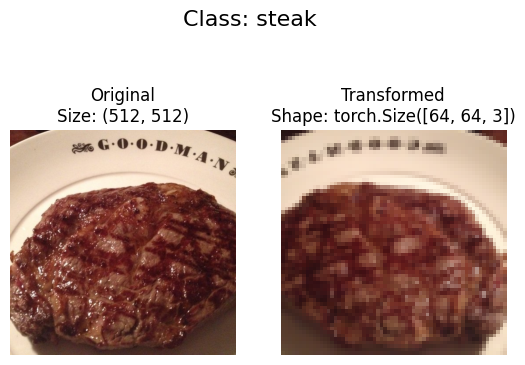

In [114]:
def plot_transformed_images(imges_paths: list, transform, n=3, seed=None):
    """ Select random images from a path of images, and load/transforms them and
    plots the original vs the transformed version."""

    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(imges_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)

            # Original
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}'); ax[0].axis(False)

            # Transformed
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}'); ax[1].axis(False)

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_path_list, transform=data_transform, n=3)


### 4. Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`

In [118]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [138]:
# Get Class names as a list
class_names = train_data.classes
print(f'{class_names = }')

# Classes as a dict
class_dict = train_data.class_to_idx
print(f'{class_dict = }')

print(f'{train_data.samples[0] = }')


class_names = ['pizza', 'steak', 'sushi']
class_dict = {'pizza': 0, 'steak': 1, 'sushi': 2}
train_data.samples[0] = ('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)


In [155]:
# Index the train_data toget a single image and label
img, label = train_data[0]
print(f'Image Shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f'Image Label: {class_names[label]}')
print(f'Label dtype: {type(label)}')

Image Shape: torch.Size([3, 64, 64])
Image dtype: torch.float32
Image Label: pizza
Label dtype: <class 'int'>


Original Shape: torch.Size([3, 64, 64])
Image Permuted: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

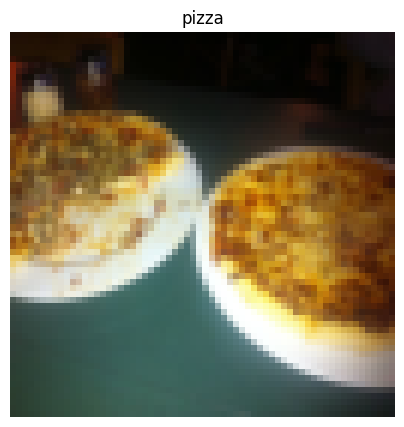

In [156]:
# Plot img
img_permuted = img.permute(1,2,0)

print(f'Original Shape: {img.shape}')
print(f'Image Permuted: {img_permuted.shape}')

# Plotting
plt.figure(figsize=(5,5))
plt.imshow(img_permuted); plt.axis(False); plt.title(class_names[label])

In [189]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 1

# Create DataLoaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f'Full Train Dataset: {len(train_data)}, Full Test Dataset: {len(test_data)} --> {BATCH_SIZE = }')
print(f'Train Dataloader:   {len(train_dataloader)}, Test Dataloader:   {len(test_dataloader)}')

Full Train Dataset: 225, Full Test Dataset: 75 --> BATCH_SIZE = 1
Train Dataloader:   225, Test Dataloader:   75


In [190]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape}')
print(f'Image label: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64])
Image label: torch.Size([1])


### 5. Option 2: Loading Image Data with a Custom `Dataset`
We want to be able to:
1. Load Images from File
2. Get Class Names from the Dataset
3. Get Classes as Dictionary from the Dataset

**Pros:**
- Can create a `Dataset` out of almost anything.
- Not limited to PyTorch pre-built `Dataset` functions.

**Cons:**
- Even though you could create `Dataset` out of almost anything, it doesn-t menan it will work...
- Using a custom `Dataset` often results in us writing more code, which is more prone to errors or performance issues.

All custom datasets in PyTorch, often subclass this `torch.utils.data.Dataset`


In [191]:
# Libraries
import os
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1. Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong)
3. Turn the class name in a dict and a list and return them.


In [200]:
# Setup path for target directory
target_directory = train_dir
print(f'Target Dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found


Target Dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [201]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""

    # 1. Get the class names from the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a directory of indez labels (computer prefers numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [202]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})